In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

#### Importing libraries

In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tensorflow as tf

#### Preparing the data

In [4]:
train_data_path = r'/kaggle/input/butterfly-image-classification/train/'
test_data_path = r'/kaggle/input/butterfly-image-classification/test/'

#### Preparing the training and validation datasets

In [105]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

df = pd.read_csv('/kaggle/input/butterfly-image-classification/Training_set.csv')
le = LabelEncoder()

df['filepath'] = df['filename'].apply(lambda x: os.path.join(train_data_path, x))
df = df.sort_values('filepath')
df['filepath'] = df['filepath'].astype(str)

# Encode labels
df['label_idx'] = le.fit_transform(df['label'])

train_df, val_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['label_idx'])

train_filepaths = train_df['filepath'].tolist()
train_labels = train_df['label_idx'].tolist()
val_filepaths = val_df['filepath'].tolist()
val_labels = val_df['label_idx'].tolist()

train_data = tf.data.Dataset.from_tensor_slices((train_filepaths, train_labels))
val_data = tf.data.Dataset.from_tensor_slices((val_filepaths, val_labels))

In [75]:
classes = sorted(df['label'].unique())

#### Loading and pre-processing images

In [106]:
def preprocess_image(path, label):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)  
    image = tf.image.resize(image, [224, 224])   
    image = tf.cast(image, tf.float32) / 255.0 
    return image, label

In [107]:
train_data = train_data.map(preprocess_image).batch(32)
val_data = val_data.map(preprocess_image).batch(32)

#### Displaying images present in the training data

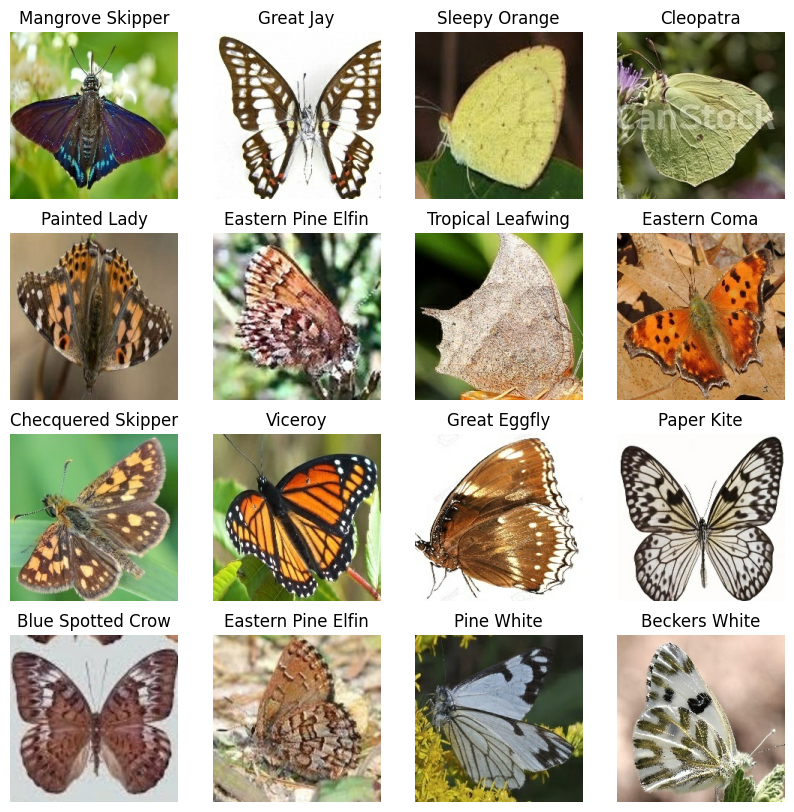

In [80]:
plt.figure(figsize=(10, 10))
for images, labels in train_data.take(1):
    for i in range(16):
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        label = labels[i].numpy()
        if isinstance(label, bytes):  
            label = label.decode()
        plt.title(label.title())
        plt.axis("off")
plt.show()

#### Defining the model

In [81]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras import layers, models

In [99]:
# EfficientNetB0 base model
base_model = EfficientNetB0(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)

inputs = tf.keras.Input(shape=(224, 224, 3))
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(len(classes), activation='softmax')(x)
model = models.Model(inputs, outputs)

# Compiling the model
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [100]:
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetb0 (Functional)          │ (None, 7, 7, 1280)          │       4,049,571 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_2           │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 75)                  │          96,075 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,145,646 (15.81 MB)

 Trainable params: 4,103,623 (15.65 MB)

 Non-trainable params: 42,023 (164.16 KB)

In [101]:
# Early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0.0001,
    patience=20,
    verbose=1,
    mode="auto",
    baseline=None,
    restore_best_weights=False,
    start_from_epoch=0,
)

In [108]:
model.fit(train_data, epochs=10, validation_data=val_data, batch_size=32, callbacks=[early_stopping])

Epoch 1/10


I0000 00:00:1751117140.384520     100 cuda_dnn.cc:529] Loaded cuDNN version 90300
E0000 00:00:1751117153.576537     100 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1751117153.719880     100 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1751117154.188865     100 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1751117154.332846     100 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1751117154.474268     100 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There m

162/163 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 0.4879 - loss: 2.2605

E0000 00:00:1751117209.883587      99 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1751117210.023136      99 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1751117210.362222      99 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1751117210.503769      99 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


163/163 ━━━━━━━━━━━━━━━━━━━━ 133s 430ms/step - accuracy: 0.4904 - loss: 2.2484 - val_accuracy: 0.0162 - val_loss: 4.4387
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 27s 164ms/step - accuracy: 0.9002 - loss: 0.3409 - val_accuracy: 0.0169 - val_loss: 4.5953
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 26s 157ms/step - accuracy: 0.9633 - loss: 0.1211 - val_accuracy: 0.0338 - val_loss: 4.5262
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 24s 150ms/step - accuracy: 0.9645 - loss: 0.1155 - val_accuracy: 0.0131 - val_loss: 4.4096
Epoch 5/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 25s 153ms/step - accuracy: 0.9726 - loss: 0.1080 - val_accuracy: 0.0138 - val_loss: 15.0297
Epoch 6/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 25s 156ms/step - accuracy: 0.9766 - loss: 0.0762 - val_accuracy: 0.0185 - val_loss: 72.0168
Epoch 7/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 25s 152ms/step - accuracy: 0.9650 - loss: 0.1294 - val_accuracy: 0.0654 - val_loss: 4.7490
Epoch 8/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 25s 152ms/step - accuracy: 0.9819 - loss: 0.0631 - 

#### Fine-tuning the model

In [109]:
base_model.trainable = True
# Re-compiling with a lower learning rate
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [110]:
# Fitting the model again
model_history = model.fit(train_data, epochs=10, validation_data=val_data, batch_size=32, callbacks=[early_stopping])

Epoch 1/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 145s 390ms/step - accuracy: 0.9689 - loss: 0.0940 - val_accuracy: 0.5138 - val_loss: 1.9227
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 26s 160ms/step - accuracy: 0.9846 - loss: 0.0585 - val_accuracy: 0.8746 - val_loss: 0.5989
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 26s 161ms/step - accuracy: 0.9861 - loss: 0.0438 - val_accuracy: 0.9031 - val_loss: 0.5192
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 24s 150ms/step - accuracy: 0.9946 - loss: 0.0283 - val_accuracy: 0.9123 - val_loss: 0.4834
Epoch 5/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 25s 152ms/step - accuracy: 0.9941 - loss: 0.0269 - val_accuracy: 0.9169 - val_loss: 0.4719
Epoch 6/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 25s 156ms/step - accuracy: 0.9979 - loss: 0.0183 - val_accuracy: 0.9169 - val_loss: 0.4660
Epoch 7/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 25s 152ms/step - accuracy: 0.9974 - loss: 0.0158 - val_accuracy: 0.9146 - val_loss: 0.4680
Epoch 8/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 25s 152ms/step - accuracy: 0.9985 - loss: 

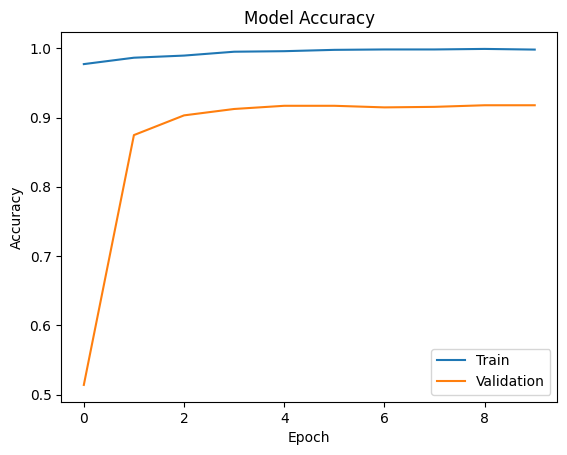

In [111]:
# Accuracy history summary
plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='best')
plt.show()

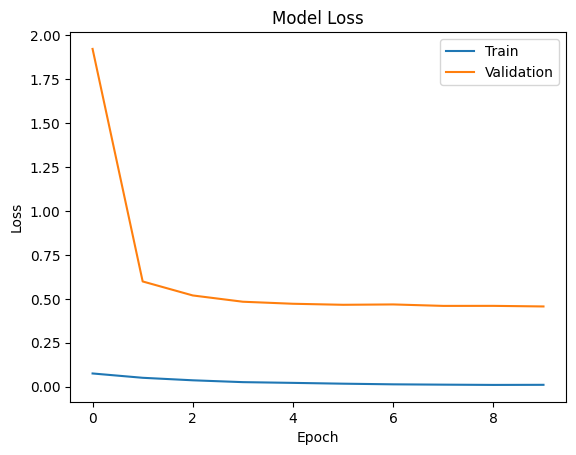

In [112]:
# Loss history summary
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='best')
plt.show()

#### Metrics

In [124]:
train_accuracy = model.evaluate(train_data)
validation_accuracy = model.evaluate(val_data)

print(f"test accuracy : {train_accuracy[1]:0.4f}")
print(f"validation accuracy : {validation_accuracy[1]:0.4f}")

163/163 ━━━━━━━━━━━━━━━━━━━━ 6s 36ms/step - accuracy: 0.9982 - loss: 0.0081
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.9161 - loss: 0.4982
test accuracy : 0.9987
validation accuracy : 0.9177


#### Saving the model

In [125]:
model.save('classifier.keras')

In [126]:
import joblib
joblib.dump(classes, 'classes.pkl')

['classes.pkl']